In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import linprog
import warnings
from portfolio_optimizer_v2 import PortfolioOptimizerV2
from pandas_datareader import data as pdr
from statsmodels.stats.correlation_tools import cov_nearest

In [2]:
# original tickers
user_tickers = ["IWDA.AS", "VAGF.DE", "IGLN.L"]

# Proxy map: use long-history proxies where possible (Yahoo tickers)
proxy_map = {
    "IWDA.AS": "^990100-USD-STRD",  # MSCI WORLD historical series
    "VAGF.DE": "VBTLX",             # Vanguard Total Bond Market mutual fund
    "IGLN.L": "IAU"                 # Gold ETF with longer history
}

opt = PortfolioOptimizerV2(user_tickers, start_date='1900-01-01', end_date=None, freq='1d',
                           risk_free_rate=0.02, inflation=0.02)

opt.fetch_data(proxy_map=proxy_map)

Fetched data for: {'IWDA.AS': '^990100-USD-STRD', 'VAGF.DE': 'VBTLX', 'IGLN.L': 'IAU'}
Price history from 1972-01-03 to 2026-02-21


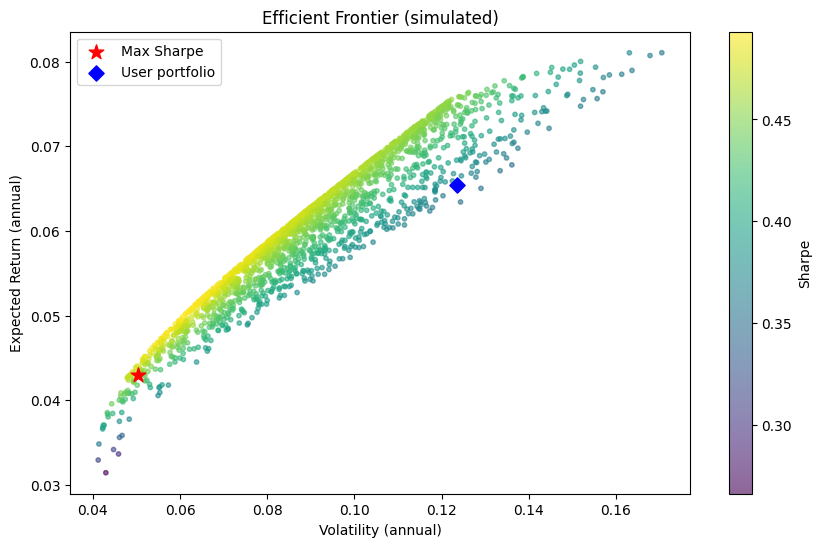


Covariance diagnostics summary across all rolling windows:
      frob_relative_change  min_eigen_raw  min_eigen_fixed  num_negative_raw  \
mean              0.014261       0.007972         0.008010               0.0   
min               0.000024       0.000672         0.000724               0.0   
max               0.188186       0.042457         0.042458               0.0   
std               0.021960       0.007633         0.007604               0.0   

      neg_variance_ratio  
mean                 0.0  
min                  0.0  
max                  0.0  
std                  0.0  


In [10]:
opt._compute_stats()
# Use geometric (CAGR) nominal returns
mu_geo = opt.get_expected_returns(method='geometric', deflate_inflation=False)
#print("Geometric (annual) returns (nominal):\n", mu_geo)

# Optionally deflate
mu_real = opt.get_expected_returns(method='geometric', deflate_inflation=True)
#print("Geometric (annual) returns (real, deflated by inflation):\n", mu_real)

# Shrink means toward economic prior (example prior in nominal terms)
# Prior order should match opt.tickers; e.g., [equities, bonds, gold] nominal
example_prior = np.array([0.065, 0.025, 0.025])  # 6.5% equities, 2.5% bonds, 2.5% gold
opt.shrink_means_empirical(prior=example_prior, lam=0.4)

# Shrink covariance
opt.shrink_covariance(delta=0.2, prior_type='single_factor')

# Optimize with bounds (force gold <= 5%)
bounds = [(0.1, 0.95), (0.1, 0.95), (0.0, 0.05)]
w_opt, perf_opt = opt.optimize_sharpe(bounds=bounds)
#print("Max Sharpe weights:", w_opt)
#print("Performance (r, vol, sharpe):", perf_opt)

# Simulate efficient frontier and plot
opt.simulate_efficient_frontier(num_portfolios=2000)
user_weights = [0.85, 0.10, 0.05]
opt.plot_efficient_frontier(user_weights=user_weights, user_label='User portfolio')


    # Only suppress RuntimeWarnings in this block
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    # Rolling backtest, using Ledoit-Wolf shrinkage for covariance and empirical mean shrink
    bt_r, bt_w = opt.rolling_backtest(window=252*3, rebalance_freq=21,
                                  method='sharpe',
                                  bounds=bounds,
                                  shrink_mean={'lam': None},      # empirical
                                  #shrink_cov={'method': 'ledoit_wolf'}
                                  shrink_cov = {
                                        "method": "hybrid_ledoit",
                                        "prior_type": "constant_correlation"
                                    }
                                  #shrink_cov={"method": "ewma", "halflife": 63}
                                     )

ann_ret, ann_vol, sharpe, maxdd = opt.backtest_stats()
#print("Backtest stats (annualized):", ann_ret, ann_vol, sharpe, "maxDD:", maxdd)

w_rp, perf_rp = opt.optimize_risk_parity(bounds=bounds)

# CVaR minimize (no target return)
w_cvar, perf_cvar, res = opt.optimize_cvar(alpha=0.95, bounds=[(0.1, 0.95), (0.1, 0.5), (0.0, 0.05)])

In [11]:
# Portfolio weights (Max Sharpe opt)
w_table = pd.DataFrame({
    "Asset": opt.tickers,
    "Weight": np.round(w_opt, 4),
    "Exp Return (nominal)": np.round(mu_geo[opt.tickers], 4),
    "Exp Return (real)": np.round(mu_real[opt.tickers], 4)
})


# Portfolio-level stats
r, vol, sharpe = perf_opt
ann_ret, ann_vol, bt_sharpe, maxdd = opt.backtest_stats()

perf_table = pd.DataFrame({
    "Metric": [
        "Optimized Portfolio Return (nominal)",
        "Optimized Portfolio Volatility",
        "Optimized Portfolio Sharpe",
        "Backtest Annual Return",
        "Backtest Annual Volatility",
        "Backtest Sharpe",
        "Backtest Max Drawdown"
    ],
    "Value": [
        round(r, 4),
        round(vol, 4),
        round(sharpe, 4),
        round(ann_ret, 4),
        round(ann_vol, 4),
        round(bt_sharpe, 4),
        round(maxdd, 4)
    ]
})

print("\n--- Asset Weights & Expected Returns (Max Sharpe) ---")
print(w_table.to_string(index=False))

print("\n--- Portfolio Performance & Backtest Stats ---")
print(perf_table.to_string(index=False))


--- Asset Weights & Expected Returns (Max Sharpe) ---
  Asset  Weight  Exp Return (nominal)  Exp Return (real)
IWDA.AS  0.2819                0.0710             0.0510
VAGF.DE  0.6681                0.0319             0.0119
 IGLN.L  0.0500                0.1213             0.1013

--- Portfolio Performance & Backtest Stats ---
                              Metric   Value
Optimized Portfolio Return (nominal)  0.0429
      Optimized Portfolio Volatility  0.0502
          Optimized Portfolio Sharpe  0.4567
              Backtest Annual Return  0.0811
          Backtest Annual Volatility  0.1149
                     Backtest Sharpe  0.5320
               Backtest Max Drawdown -0.5136


In [5]:
# Risk parity results
r_rp, vol_rp, sharpe_rp = perf_rp

# weights table
w_table_rp = pd.DataFrame({
    "Asset": opt.tickers,
    "Weight": np.round(w_rp, 4),
    #"Exp Return (nominal)": np.round(mu_geo[opt.tickers], 4),
    #"Exp Return (real)": np.round(mu_real[opt.tickers], 4)
})

# performance table
perf_table_rp = pd.DataFrame({
    "Metric": [
        "Risk Parity Portfolio Return (nominal)",
        "Risk Parity Portfolio Volatility",
        "Risk Parity Portfolio Sharpe"
    ],
    "Value": [
        round(r_rp, 4),
        round(vol_rp, 4),
        round(sharpe_rp, 4)
    ]
})

print("\n--- Risk Parity Asset Weights & Expected Returns ---")
print(w_table_rp.to_string(index=False))

print("\n--- Risk Parity Portfolio Performance ---")
print(perf_table_rp.to_string(index=False))


--- Risk Parity Asset Weights & Expected Returns ---
  Asset  Weight
IWDA.AS  0.1003
VAGF.DE  0.8512
 IGLN.L  0.0485

--- Risk Parity Portfolio Performance ---
                                Metric  Value
Risk Parity Portfolio Return (nominal) 0.0357
      Risk Parity Portfolio Volatility 0.0417
          Risk Parity Portfolio Sharpe 0.3761


In [6]:
# CVaR results 
r_cvar, vol_cvar, sharpe_cvar = perf_cvar

# weights table
w_table_cvar = pd.DataFrame({
    "Asset": opt.tickers,
    "Weight": np.round(w_cvar, 4),
    #"Exp Return (nominal)": np.round(mu_geo[opt.tickers], 4),
    #"Exp Return (real)": np.round(mu_real[opt.tickers], 4)
})

# performance table
perf_table_cvar = pd.DataFrame({
    "Metric": [
        "CVaR Portfolio Return (nominal)",
        "CVaR Portfolio Volatility",
        "CVaR Portfolio Sharpe"
    ],
    "Value": [
        round(r_cvar, 4),
        round(vol_cvar, 4),
        round(sharpe_cvar, 4)
    ]
})

print("\n--- CVaR Asset Weights & Expected Returns ---")
print(w_table_cvar.to_string(index=False))

print("\n--- CVaR Portfolio Performance ---")
print(perf_table_cvar.to_string(index=False))


--- CVaR Asset Weights & Expected Returns ---
  Asset  Weight
IWDA.AS    0.45
VAGF.DE    0.50
 IGLN.L    0.05

--- CVaR Portfolio Performance ---
                         Metric  Value
CVaR Portfolio Return (nominal) 0.0496
      CVaR Portfolio Volatility 0.0683
          CVaR Portfolio Sharpe 0.4332


In [7]:
## Backtest with turnover
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)

    bt_tc, w_tc_hist = opt.rolling_backtest(
        window=756,          # 3 years
        rebalance_freq=21,  # monthly
        method="sharpe_tc",
        gamma=5e-3,         # turnover penalty
        bounds=[(0.1,0.95),(0.1,0.95),(0,0.05)],
        shrink_mean={"lam": None},
        shrink_cov={"method":"ledoit_wolf"}
    )

opt.backtest_stats()

ann_ret_tc, ann_vol_tc, bt_sharpe_tc, maxdd_tc = opt.backtest_stats()

perf_table = pd.DataFrame({
    "Metric": [
        "Backtest Annual Return",
        "Backtest Annual Volatility",
        "Backtest Sharpe",
        "Backtest Max Drawdown"
    ],
    "Value": [
        round(ann_ret_tc, 4),
        round(ann_vol_tc, 4),
        round(bt_sharpe_tc, 4),
        round(maxdd_tc, 4)
    ]
})

print("\n--- Portfolio perf. with turnover, backtest stats ---")
print(perf_table.to_string(index=False))


Covariance diagnostics summary across all rolling windows:
      frob_relative_change  min_eigen_raw  min_eigen_fixed  num_negative_raw  \
mean              0.037225       0.007972         0.008284               0.0   
min               0.001323       0.000672         0.000830               0.0   
max               0.728234       0.042457         0.042401               0.0   
std               0.105241       0.007633         0.007378               0.0   

      neg_variance_ratio  
mean                 0.0  
min                  0.0  
max                  0.0  
std                  0.0  

--- Portfolio perf. with turnover, backtest stats ---
                    Metric   Value
    Backtest Annual Return  0.0822
Backtest Annual Volatility  0.1151
           Backtest Sharpe  0.5402
     Backtest Max Drawdown -0.5136


In [5]:
## checking the tickers
ticker = "^990100-USD-STRD"

df = yf.download(
    ticker,
    start="1900-01-01",   # safely before any modern index
    end=pd.Timestamp.today().strftime("%Y-%m-%d"),
    auto_adjust=False,
    progress=False
)

print("First date:", df.index.min())
print("Last date:", df.index.max())
print("Number of rows:", len(df))

print("\nColumns:")
print(df.columns)

print("\nHead:")
print(df.head())

print("\nTail:")
print(df.tail())

First date: 1972-01-03 00:00:00
Last date: 2026-02-13 00:00:00
Number of rows: 13860

Columns:
MultiIndex([('Adj Close', '^990100-USD-STRD'),
            (    'Close', '^990100-USD-STRD'),
            (     'High', '^990100-USD-STRD'),
            (      'Low', '^990100-USD-STRD'),
            (     'Open', '^990100-USD-STRD'),
            (   'Volume', '^990100-USD-STRD')],
           names=['Price', 'Ticker'])

Head:
Price             Adj Close            Close             High  \
Ticker     ^990100-USD-STRD ^990100-USD-STRD ^990100-USD-STRD   
Date                                                            
1972-01-03       104.300003       104.300003       104.300003   
1972-01-04       104.599998       104.599998       104.599998   
1972-01-05       105.599998       105.599998       105.599998   
1972-01-06       110.800003       110.800003       110.800003   
1972-01-07       110.900002       110.900002       110.900002   

Price                   Low             Open           V

In [6]:
# Any gaps?
print("NaN counts:\n", df.isna().sum())

# Daily coverage per year
years = df.index.year.value_counts().sort_index()
print("\nObservations per year:\n", years.head(), "\n...\n", years.tail())

NaN counts:
 Price      Ticker          
Adj Close  ^990100-USD-STRD    0
Close      ^990100-USD-STRD    0
High       ^990100-USD-STRD    0
Low        ^990100-USD-STRD    0
Open       ^990100-USD-STRD    0
Volume     ^990100-USD-STRD    0
dtype: int64

Observations per year:
 Date
1972    259
1973    259
1974    259
1975    259
1976    261
Name: count, dtype: int64 
...
 Date
2022    249
2023    251
2024    251
2025    253
2026     30
Name: count, dtype: int64


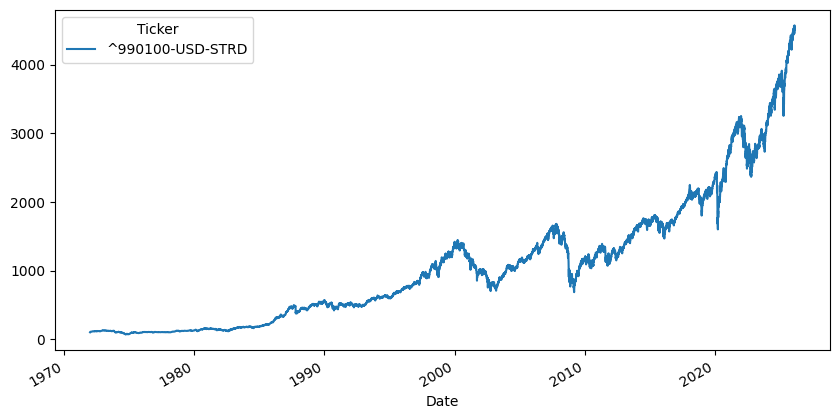

In [7]:
df['Adj Close'].plot(figsize=(10,5));

In [13]:
start = "1960-01-01"

test_series = {
    "GS10": "10Y Treasury Yield",
    "CPIAUCSL": "CPI All Urban Consumers"
}

for code, name in test_series.items():
    try:
        s = pdr.DataReader(code, "fred", start)
        print(f"\n{name} ({code})")
        print("Start:", s.index[0].date())
        print("End  :", s.index[-1].date())
        print("Tail:")
        print(s.tail())
    except Exception as e:
        print(f" {code} failed:", e)



10Y Treasury Yield (GS10)
Start: 1960-01-01
End  : 2026-01-01
Tail:
            GS10
DATE            
2025-09-01  4.12
2025-10-01  4.06
2025-11-01  4.09
2025-12-01  4.14
2026-01-01  4.21

CPI All Urban Consumers (CPIAUCSL)
Start: 1960-01-01
End  : 2026-01-01
Tail:
            CPIAUCSL
DATE                
2025-09-01   324.245
2025-10-01       NaN
2025-11-01   325.063
2025-12-01   326.031
2026-01-01   326.588
